In [2]:
import matplotlib.pyplot as plt
import numpy as np

import pyxdf

In [3]:
WPI_xdf_path = "../HCILab1-Group4.xdf"
CSL_xdf_path = "../CSL_Laptop_1010.xdf"

### View XDF Streams

In [4]:
def view_xdf_streams(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    print(header)

    for stream in data:
        stream_name = stream["info"]["name"][0]
        stream_id = stream["info"]["stream_id"]
        stream_srate = stream["info"]["effective_srate"]
        
        print(f'Stream {stream_name} (Stream ID: {stream_id} with sampling rate {stream_srate})')

In [5]:
view_xdf_streams(WPI_xdf_path)

Stream 4: Calculated effective sampling rate 16.6432 Hz is different from specified rate 30.0000 Hz.


{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-10-10T09:50:58-0400']})}
Stream Unicorn_HCILab1 (Stream ID: 5 with sampling rate 249.14369333646374)
Stream OBS_HCILab1 (Stream ID: 1 with sampling rate 30.000000238112424)
Stream Unicorn_HCILab2 (Stream ID: 3 with sampling rate 240.4448060049622)
Stream OBS_HCILab2 (Stream ID: 4 with sampling rate 16.6431919621109)
Stream Unicorn_CSL_LabPC (Stream ID: 6 with sampling rate 250.24774486207198)
Stream OBS_CSL_Laptop (Stream ID: 2 with sampling rate 29.99982375546662)


In [6]:
view_xdf_streams(CSL_xdf_path)

{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-10-10T15:51:10+0200']})}
Stream Unicorn_CSL_Laptop (Stream ID: 1 with sampling rate 250.1055502862692)
Stream OBS_CSL_Laptop (Stream ID: 4 with sampling rate 30.000000292560014)
Stream OBS_CSL_LabPC (Stream ID: 6 with sampling rate 60.000581508947754)
Stream Unicorn_CSL_LabPC (Stream ID: 3 with sampling rate 250.24905436363383)
Stream OBS_HCILab1 (Stream ID: 2 with sampling rate 30.000176797664754)
Stream Unicorn_HCILab1 (Stream ID: 5 with sampling rate 249.2068722981212)


WPI HCI Lab Streams:


Stream 4: Calculated effective sampling rate 16.6432 Hz is different from specified rate 30.0000 Hz.


Stream Unicorn_HCILab1 has 1038687 time stamps, starting with 116357.09399525668


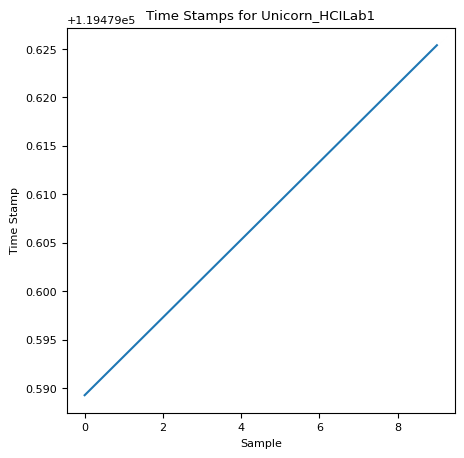

Stream OBS_HCILab1 has 125008 time stamps, starting with 116360.86172997921
Stream OBS_HCILab1 with time series (UNIX) begins with 1728568258.294
Stream Unicorn_HCILab2 has 891323 time stamps, starting with 116332.10106008347
YAY


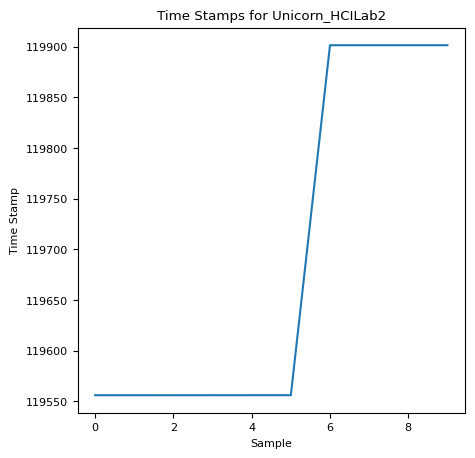

Stream OBS_HCILab2 has 67134 time stamps, starting with 116321.53340890662
Stream OBS_HCILab2 with time series (UNIX) begins with 1728568258.561
Stream Unicorn_CSL_LabPC has 1024897 time stamps, starting with 116360.91246072728


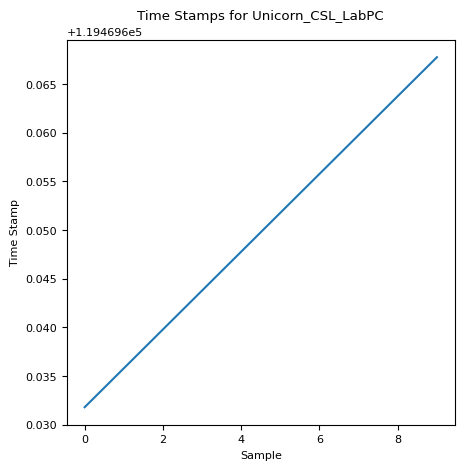

Stream OBS_CSL_Laptop has 114510 time stamps, starting with 116361.01773825992
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1728568258.57

CSL Lab Streams:
Stream Unicorn_CSL_Laptop has 1003675 time stamps, starting with 5635240.491963036


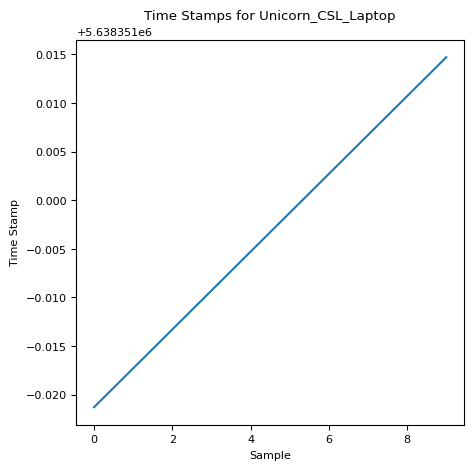

Stream OBS_CSL_Laptop has 120387 time stamps, starting with 5635240.682931772
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1728568270.336
Stream OBS_CSL_LabPC has 240778 time stamps, starting with 5635240.654745839
Stream OBS_CSL_LabPC with time series (UNIX) begins with 1728568270.407
Stream Unicorn_CSL_LabPC has 1004248 time stamps, starting with 5635240.561731037


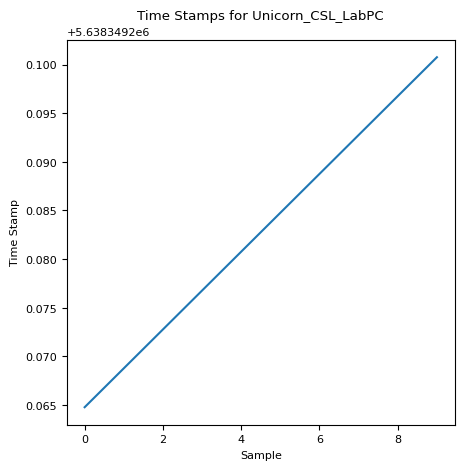

Stream OBS_HCILab1 has 116389 time stamps, starting with 5635240.826842812
Stream OBS_HCILab1 with time series (UNIX) begins with 1728568270.36
Stream Unicorn_HCILab1 has 966806 time stamps, starting with 5635237.413491724


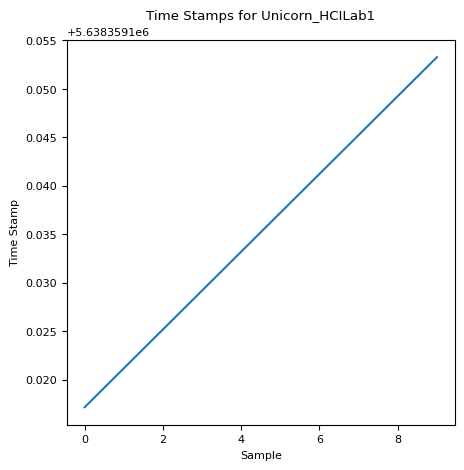

In [20]:
def examine_timestamps_length(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    
    for stream in data:
        stream_name = stream["info"]["name"][0]
        
        time_stamps = stream["time_stamps"]
        
        print(f'Stream {stream_name} has {len(time_stamps)} time stamps, starting with {time_stamps[0]}')
        
        time_series = stream["time_series"]
        if stream_name.startswith("OBS"):
            print(f"Stream {stream_name} with time series (UNIX) begins with {time_series[0][0]}")
            
        if stream_name == "Unicorn_HCILab2":
            print("YAY")
            for i in range(0, len(time_stamps) - 1):
                if time_stamps[i] == time_stamps[i + 1]:
                    print(f"Time stamp {time_stamps[i]} is repeated at index {i}")
                    break
        
        if "Unicorn" in stream_name:
            # plot the time stamps
            plt.rc('font', size=8)
            plt.figure(figsize=(5, 5))
            plt.plot(time_stamps[777950: 777950 + 10])
            plt.xlabel('Sample')
            plt.ylabel('Time Stamp')
            plt.title(f"Time Stamps for {stream_name}")
            plt.show()


# Examine the length of all time stamps in each stream for both XDF files
print("WPI HCI Lab Streams:")
examine_timestamps_length(WPI_xdf_path)

print("\nCSL Lab Streams:")
examine_timestamps_length(CSL_xdf_path)

### Sync Streams!!

In [7]:
def sync_streams(data_streams_1, data_streams_2):
    
    """
    Sync the data by trimming time_stamp and time_series streams so that all EEG and Unicorn Streams begin at the same time
    
    Parameters:
    - data_streams_1: Stream data from WPI HCI Lab xdf file
    - data_streams_2: Stream data from CSL Lab xdf file
    """
    
    # Holds the 8 streams (4 OBS and 4 Unicorn)
    streams = {}
    
    # Create mappings of the 8 stream names to streams
    for stream in data_streams_1:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_HCILab1", "Unicorn_HCILab1", "OBS_HCILab2", "Unicorn_HCILab2"]:
            streams[stream_name] = stream
            
    for stream in data_streams_2:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_CSL_Laptop", "Unicorn_CSL_Laptop", "OBS_CSL_LabPC", "Unicorn_CSL_LabPC"]:
            streams[stream_name] = stream
    
    # From the OBS Video (when Chris says "Begin" and "Time's Up")
    start_unix_timestamp = 1728395421.629
    end_unix_timestamp = 1728399090.212
    duration = end_unix_timestamp - start_unix_timestamp
    frames = 250 * duration
    
    # Trim all the other streams based on the latest Unix timestamp
    for OBS_stream_name, EEG_stream_name in [("OBS_HCILab1", "Unicorn_HCILab1"), ("OBS_HCILab2", "Unicorn_HCILab2"), ("OBS_CSL_Laptop", "Unicorn_CSL_Laptop"), ("OBS_CSL_LabPC", "Unicorn_CSL_LabPC")]:
        OBS_stream = streams[OBS_stream_name]
        EEG_stream = streams[EEG_stream_name]
        
        # First, find the LabRecorder timestamp in the OBS stream that corresponds to the start and end Unix timestamp
        OBS_unix_times = [ts[0] for ts in OBS_stream["time_series"]]
        start_OBS_index = np.searchsorted(OBS_unix_times, start_unix_timestamp)
        end_OBS_index = np.searchsorted(OBS_unix_times, end_unix_timestamp)
        
        start_labrecorder_timestamp = OBS_stream["time_stamps"][start_OBS_index]
        
        # Find the index in the EEG stream where this LabRecorder timestamp occurs
        start_EEG_index = np.searchsorted(EEG_stream["time_stamps"], start_labrecorder_timestamp)
        end_EEG_index = start_EEG_index + round(frames)
        
        # Trim all the data in the OBS and EEG streams based on this index
        OBS_stream["time_stamps"] = OBS_stream["time_stamps"][start_OBS_index:end_OBS_index]
        OBS_stream["time_series"] = OBS_stream["time_series"][start_OBS_index:end_OBS_index]
        EEG_stream["time_stamps"] = EEG_stream["time_stamps"][start_EEG_index:end_EEG_index]
        EEG_stream["time_series"] = EEG_stream["time_series"][start_EEG_index:end_EEG_index]
    
    return streams

In [8]:
# Load the XDF data for both labs
WPI_data_streams, WPI_header = pyxdf.load_xdf(WPI_xdf_path)
CSL_data_streams, CSL_header = pyxdf.load_xdf(CSL_xdf_path)

Stream 4: Calculated effective sampling rate 16.6432 Hz is different from specified rate 30.0000 Hz.


In [9]:
# Before syncing the streams, let's examine the time_stamps and time_series in both files
def print_time_stamps_and_series(data_streams):
    for stream in data_streams:
        stream_name = stream["info"]["name"][0]
        print(f'\nStream {stream_name} has {len(stream["time_stamps"])} time stamps and {len(stream["time_series"])} time series')
        
        if len(stream["time_stamps"]) > 0:
            print(f'Time stamps: [{stream["time_stamps"][0]} ... {stream["time_stamps"][-1]}]')
        
        if stream_name.startswith("OBS") and len(stream["time_series"]) > 0:
            print(f'Time series (UNIX): [{stream["time_series"][0][0]} ... {stream["time_series"][-1][0]}]')
        
print("WPI HCI Lab Streams before syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams before syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams before syncing:

Stream Unicorn_HCILab1 has 1038687 time stamps and 1038687 time series
Time stamps: [116357.09399525668 ... 120526.11786062301]

Stream OBS_HCILab1 has 125008 time stamps and 125008 time series
Time stamps: [116360.86172997921 ... 120527.76169690592]
Time series (UNIX): [1728568258.294 ... 1728572425.194]

Stream Unicorn_HCILab2 has 891323 time stamps and 891323 time series
Time stamps: [116332.10106008347 ... 120384.47360887547]

Stream OBS_HCILab2 has 67134 time stamps and 67134 time series
Time stamps: [116321.53340890662 ... 120355.22150069618]
Time series (UNIX): [1728568258.561 ... 1728572269.327]

Stream Unicorn_CSL_LabPC has 1024897 time stamps and 1024897 time series
Time stamps: [116360.91246072728 ... 120456.43787524763]

Stream OBS_CSL_Laptop has 114510 time stamps and 114510 time series
Time stamps: [116361.01773825992 ... 120527.70888179594]
Time series (UNIX): [1728568258.57 ... 1728572425.262]

CSL Lab Streams before syncing:

Stream

In [10]:
# Sync the streams based on the shared stream's timestamp
streams = sync_streams(WPI_data_streams, CSL_data_streams)

In [11]:
print("WPI HCI Lab Streams AFTER syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams AFTER syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams AFTER syncing:

Stream Unicorn_HCILab1 has 917146 time stamps and 917146 time series
Time stamps: [116360.86290463794 ... 120042.05182313823]

Stream OBS_HCILab1 has 0 time stamps and 0 time series

Stream Unicorn_HCILab2 has 891323 time stamps and 891323 time series
Time stamps: [116332.10106008347 ... 120384.47360887547]

Stream OBS_HCILab2 has 0 time stamps and 0 time series

Stream Unicorn_CSL_LabPC has 1024897 time stamps and 1024897 time series
Time stamps: [116360.91246072728 ... 120456.43787524763]

Stream OBS_CSL_Laptop has 114510 time stamps and 114510 time series
Time stamps: [116361.01773825992 ... 120527.70888179594]
Time series (UNIX): [1728568258.57 ... 1728572425.262]

CSL Lab Streams AFTER syncing:

Stream Unicorn_CSL_Laptop has 917146 time stamps and 917146 time series
Time stamps: [5635240.683882008 ... 5638907.715655451]

Stream OBS_CSL_Laptop has 0 time stamps and 0 time series

Stream OBS_CSL_LabPC has 0 time stamps and 0 time series

Stream Un

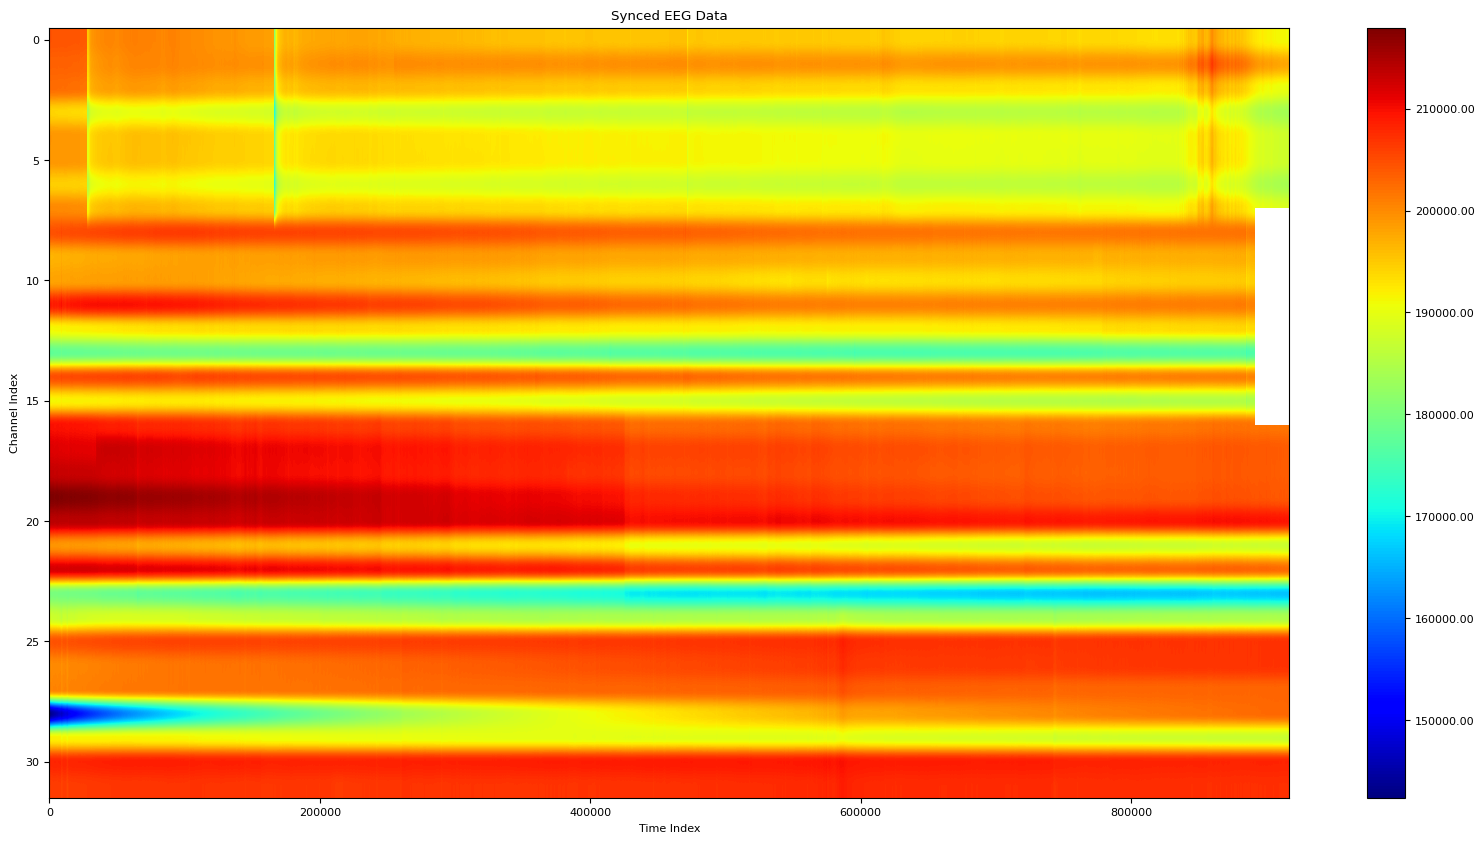

Min: 142394.375
Max: 217938.71875
Mean: 197104.40271202428
Standard Deviation: 10126.966048364304


In [12]:
import scipy.io

# Disable scientific notation in NumPy globally
np.set_printoptions(suppress=True)

# find the max length of time_series in all EEG streams to establish dimensions for synced EEG streams
max_length = 0

for stream_name in ["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop", "Unicorn_CSL_LabPC"]:
    max_length = max(max_length, len(streams[stream_name]["time_series"]))

# Create an np array to hold the synced EEG data with dimensions (max_length, 4 * 8)
synced_EEG_data = np.full((max_length, 4 * 8), np.nan)

# Fill in the synced EEG data
for j, stream_name in enumerate(["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop", "Unicorn_CSL_LabPC"]):
    EEG_stream = streams[stream_name]
    
    for time_index, eeg_data in enumerate(EEG_stream["time_series"]):
        synced_EEG_data[time_index, j * 8:(j + 1) * 8] = eeg_data[0:8]

# Visualize the synced EEG data
plt.figure(figsize=(20, 10))
plt.imshow(synced_EEG_data.T, aspect='auto', cmap='jet')
plt.colorbar(format='%.2f')  # Ensures color bar does not use scientific notation
plt.title("Synced EEG Data")
plt.xlabel("Time Index")
plt.ylabel("Channel Index")
plt.show()

print("Min:", np.nanmin(synced_EEG_data))
print("Max:", np.nanmax(synced_EEG_data))
print("Mean:", np.nanmean(synced_EEG_data))
print("Standard Deviation:", np.nanstd(synced_EEG_data))

# Download the EEG data as an .mat file
# scipy.io.savemat('task_cutoff_EEG_data_4.mat', {'task_cutoff_EEG_data_4': synced_EEG_data})